The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# Identificação de Raça de Cachorro (*ImageNet Dogs*) no Kaggle

Nesta seção, abordaremos o desafio da identificação de raças de cães na Competição Kaggle. O endereço da competição na web é

> https://www.kaggle.com/c/dog-breed-identification


Nesta competição, tentamos identificar 120 raças diferentes de cães. O conjunto de dados usado nesta competição é, na verdade, um subconjunto do famoso conjunto de dados ImageNet. Diferente das imagens no conjunto de dados CIFAR-10 usado na seção anterior, as imagens no conjunto de dados ImageNet são mais altas e mais largas e suas dimensões são inconsistentes.

:numref:`fig_kaggle_dog` mostra as informações na página da competição. Para enviar os resultados, primeiro registre uma conta no site do Kaggle.

![Site de competição de identificação de raças de cães. O conjunto de dados da competição pode ser acessado clicando na guia "Data".](../img/kaggle-dog.jpg)
:width:`400px`
:label:`fig_kaggle_dog`

Primeiro, importe os pacotes ou módulos necessários para a competição.


In [1]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

## Obtenção e organização do *Dataset*

Os dados da competição são divididos em um conjunto de treinamento e um conjunto de teste. O conjunto de treinamento contém $10.222$ imagens e o conjunto de teste contém $10.357$ imagens. As imagens em ambos os conjuntos estão no formato JPEG. Essas imagens contêm três canais RGB (cores) e diferentes alturas e larguras. Existem 120 raças de cães no conjunto de treinamento, incluindo Labradores, Poodles, Dachshunds, Samoyeds, Huskies, Chihuahuas e Yorkshire Terriers.

### Baixando o Dataset

Depois de fazer o login no Kaggle, podemos clicar na guia "Data" na página da competição de identificação de raças de cães mostrada em :numref:`fig_kaggle_dog` e baixar o conjunto de dados clicando no botão" Baixar tudo ". Após descompactar o arquivo baixado em `../data`, você encontrará todo o conjunto de dados nos seguintes caminhos:

* ../data/dog-breed-identification/labels.csv
* ../data/dog-breed-identification/sample_submission.csv
* ../data/dog-breed-identification/train
* ../data/dog-breed-identification/test


Você deve ter notado que a estrutura acima é bastante semelhante à da competição CIFAR-10 em :numref:`sec_kaggle_cifar10`, onde as pastas `train/` e `test/` contêm imagens de treinamento e teste de cães, respectivamente, e `rótulos. csv` tem os rótulos das imagens de treinamento.

Da mesma forma, para facilitar o início, fornecemos uma amostra em pequena escala do conjunto de dados mencionado acima, "train_valid_test_tiny.zip". Se você for usar o conjunto de dados completo para a competição Kaggle, você também precisará alterar a variável `demo` abaixo para `False`.


In [2]:
#@save
d2l.DATA_HUB['dog_tiny'] = (d2l.DATA_URL + 'kaggle_dog_tiny.zip',
                            '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')

# If you use the full dataset downloaded for the Kaggle competition, change
# the variable below to False
demo = True
if demo:
    data_dir = d2l.download_extract('dog_tiny')
else:
    data_dir = os.path.join('..', 'data', 'dog-breed-identification')

### Organizando o Dataset


Podemos organizar o conjunto de dados de forma semelhante ao que fizemos em :numref:`sec_kaggle_cifar10`, nomeadamente separando um conjunto de validação do conjunto de treinamento e movendo imagens em subpastas agrupadas por rótulos.

A função `reorg_dog_data` abaixo é usada para ler os rótulos dos dados de treinamento, segmentar o conjunto de validação e organizar o conjunto de treinamento.


In [3]:
def reorg_dog_data(data_dir, valid_ratio):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)


batch_size = 4 if demo else 128
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

## Aumento de Imagem

O tamanho das imagens nesta seção é maior do que as imagens na seção anterior. Aqui estão mais algumas operações de aumento de imagem que podem ser úteis.


In [4]:
transform_train = torchvision.transforms.Compose([
    # Randomly crop the image to obtain an image with an area of 0.08 to 1 of
    # the original area and height to width ratio between 3/4 and 4/3. Then,
    # scale the image to create a new image with a height and width of 224
    # pixels each
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                             ratio=(3.0/4.0, 4.0/3.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    # Randomly change the brightness, contrast, and saturation
    torchvision.transforms.ColorJitter(brightness=0.4,
                                       contrast=0.4,
                                       saturation=0.4),
    # Add random noise
    torchvision.transforms.ToTensor(),
    # Standardize each channel of the image
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

Durante o teste, usamos apenas operações de pré-processamento de imagens definidas.


In [5]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    # Crop a square of 224 by 224 from the center of the image
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

## Lendo o Dataset

Como na seção anterior, podemos criar uma instância `ImageFolderDataset` para ler o conjunto de dados contendo os arquivos de imagem originais.


In [6]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

Aqui, criamos instâncias de `DataLoader`, assim como em :numref:`sec_kaggle_cifar10`.


In [7]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

## Definindo o Modelo


O conjunto de dados para esta competição é um subconjunto dos dados ImageNet. Portanto, podemos usar a abordagem discutida em :numref:`sec_fine_tuning` para selecionar um modelo pré-treinado em
todo o conjunto de dados ImageNet e usá-lo para extrair recursos de imagem a serem inseridos na rede de saída de pequena escala personalizada. A Gluon oferece uma ampla gama de modelos pré-treinados. Aqui, usaremos o modelo ResNet-34 pré-treinado. Como o conjunto de dados da competição é um subconjunto do conjunto de dados de pré-treinamento, simplesmente reutilizamos a entrada da camada de saída do modelo pré-treinado, ou seja, os recursos extraídos. Então, podemos substituir a camada de saída original por uma pequena camada personalizada de
rede de saída que pode ser treinada, como duas camadas totalmente conectadas em uma série. Diferente da experiência em
:numref:`sec_fine_tuning`, aqui, não retreinamos o modelo pré-treinado usado para extração de características. Isso reduz o tempo de treinamento e a memória necessária para armazenar gradientes de parâmetro do modelo.

Você deve notar que, durante o aumento da imagem, usamos os valores médios e desvios padrão dos três canais RGB para todo o conjunto de dados ImageNet para normalização. Isso é consistente com a normalização do modelo pré-treinado.


In [8]:
def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(pretrained=True)
    # Define a new output network
    # There are 120 output categories
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256),
                                            nn.ReLU(),
                                            nn.Linear(256, 120))
    # Move model to device
    finetune_net = finetune_net.to(devices[0])
    # Freeze feature layer params
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net

Ao calcular a perda, primeiro usamos a variável-membro `features` para obter a entrada da camada de saída do modelo pré-treinado, ou seja, a característica extraída. Em seguida, usamos essa característica como a entrada para nossa pequena rede de saída personalizada e calculamos a saída.


In [9]:
loss = nn.CrossEntropyLoss(reduction='none')

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum = l.sum()
        n += labels.numel()
    return l_sum / n

## Definindo as Funções de Treinamento

Selecionaremos o modelo e ajustaremos os hiperparâmetros de acordo com o desempenho do modelo no conjunto de validação. A função de treinamento do modelo `treinar` apenas treina a pequena rede de saída personalizada.


In [10]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    # Only train the small custom output network
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.SGD((param for param in net.parameters()
                               if param.requires_grad), lr=lr,
                              momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'valid loss'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            features, labels = features.to(devices[0]), labels.to(devices[0])
            trainer.zero_grad()
            output = net(features)
            l = loss(output, labels).sum()
            l.backward()
            trainer.step()
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss))
        scheduler.step()
    if valid_iter is not None:
        print(f'train loss {metric[0] / metric[1]:.3f}, '
              f'valid loss {valid_loss:.3f}')
    else:
        print(f'train loss {metric[0] / metric[1]:.3f}')
    print(f'{metric[1] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

## Treinamento e Validação do Modelo

Agora podemos treinar e validar o modelo. Os hiperparâmetros a seguir podem ser ajustados. Por exemplo, podemos aumentar o número de épocas. Como `lr_period` e` lr_decay` são definidos como 10 e 0,1 respectivamente, a taxa de aprendizado do algoritmo de otimização será multiplicada por 0,1 a cada 10 épocas.


train loss 3.740, valid loss 0.125
107.6 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


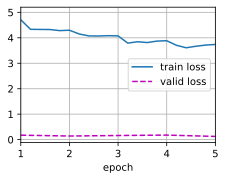

In [11]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 5, 0.001, 1e-4
lr_period, lr_decay, net = 10, 0.1, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

## Classificando o Conjunto de Testes e Enviando Resultados no Kaggle

Depois de obter um design de modelo satisfatório e hiperparâmetros, usamos todos os conjuntos de dados de treinamento (incluindo conjuntos de validação) para treinar novamente o modelo e, em seguida, classificar o conjunto de teste. Observe que as previsões são feitas pela rede de saída que acabamos de treinar.


train loss 3.779
126.4 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


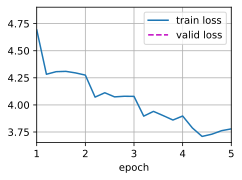

In [12]:
net = get_net(devices)
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

preds = []
for data, label in test_iter:
    output = torch.nn.functional.softmax(net(data.to(devices[0])), dim=0)
    preds.extend(output.cpu().detach().numpy())
ids = sorted(os.listdir(
    os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))
with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
    for i, output in zip(ids, preds):
        f.write(i.split('.')[0] + ',' + ','.join(
            [str(num) for num in output]) + '\n')

Após executar o código acima, geraremos um arquivo "submit.csv". O formato deste arquivo é consistente com os requisitos da competição Kaggle. O método para enviar resultados é semelhante ao método em :numref:`sec_kaggle_house`.


## Resumo

* Podemos usar um modelo pré-treinado no conjunto de dados ImageNet para extrair recursos e treinar apenas uma pequena rede de saída personalizada. Isso nos permitirá classificar um subconjunto do conjunto de dados ImageNet com menor sobrecarga de computação e armazenamento.


## Exercícios

1. Ao usar todo o conjunto de dados Kaggle, que tipo de resultados você obtém ao aumentar `batch_size` (tamanho do lote) e` num_epochs` (número de épocas)?
1. Você obtém melhores resultados se usar um modelo pré-treinado mais profundo?
1. Digitalize o código QR para acessar as discussões relevantes e trocar ideias sobre os métodos usados e os resultados obtidos com a comunidade. Você pode sugerir técnicas melhores?


[Discussões](https://discuss.d2l.ai/t/1481)


<!--stackedit_data:
eyJoaXN0b3J5IjpbNTMyMzA0MTIyLC00MzkzMzIzOTcsMjEyNT
Q0NDczOCwtNDU1MTg0MDExLC04ODg5MTU4NjIsLTc5MTMzMjk0
LDU1OTE1MDM2NF19
-->
